# Modules and Functions

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import json
import re
import nltk
import spacy
from langdetect import detect
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim import corpora, models, similarities, downloader
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [1]:
# def select_english(df):
#     """Select reviews written in English language."""
#     language = []
#     errors = []
#     for i, text in enumerate(df['text']):
#         try:
#             language.append(detect(text))
#         except:
#             language.append('error')
#     df['language'] = language
#     df = df[df['language'] == 'en']
#     return df


# def checker(text):
#     """Check if text contains words written in English."""
#     try:
#         return detect(text)
#     except:
#         return 'error'


def tokenize(df):
    """Tokenize the text."""
    tokenizer = RegexpTokenizer(r'[^\s,\.\-\?!:;\(\)\"\"\#\$\%\&\*\/0-9]+')
    tokenized = [" ".join(tokenizer.tokenize(
                df['text'].values[i].lower()))
                for i in range(df.shape[0])]
    df['tokenized_text'] = tokenized
    return df


def remove_stopwords(df):
    """Remove stop words from the tokenized text."""
    stop_words = stopwords.words('english')
    stop_words += ['what\'s', 'there\'s', 'that\'s', 'i\'m', 'pm', 'am', 'nn',
                   'we\'re', 'i\'ve', 'i\'ll', 'i\'d', 'etc', 
                   'would', 'also', 'act', 'fund', 'purpose', 'establish',
                   'therefor', 'amend', 'provide', 'appropriating', 
                   'otherwise', 'republic', 'philippine', 'know', 'create',
                   'institutionalize', 'section', 'institute', 'strengthen', 
                   'appropriate', 'office', 'authority', 'declare']
    stopped = ([" ".join([text for text in
                         [word for word in
                          df['tokenized_text'].values[i].split()]
                          if text not in stop_words])
                for i in range(df.shape[0])])
    df['stopped_text'] = stopped
    return df


def lemmatize(df):
    """Lemmatize the texts without stop words."""
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    stemmed = ([" ".join([token.lemma_ for token in
                          nlp(df['stopped_text'].values[i])])
                for i in range(df.shape[0])])
    df['stemmed_text'] = stemmed
    return df


def tfidf_converter(text_array):
    """Return a tf-idf matrix from an array containing text data.

    Parameters
    ----------
    text_array : np.array
        A numpy array that represents the corpus, which would be converted
        to a tf-idf matrix.

    Returns
    -------
    tfidf : scipy.sparse.csr.csr_matrix
        A sparse matrix in compressed sparse row (CSR) format which serves as
        the tf-idf representation of the entire corpus.
    """
    corpus = [text_array[i] for i in range(text_array.shape[0])]
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(corpus)
    columns = vectorizer.get_feature_names()
    return tfidf, columns


def wordcloud_frame(tfidf, stopwords, columns):
    """Return the sum of the tfidf scores of all words in the corpus."""
    words_df = pd.DataFrame(tfidf.toarray().sum(axis=0)).T
    words_df.columns = columns
    words_df = words_df.drop(stopwords, axis=1)
    words_df = words_df.T
    words_df.columns = ['tfidf_score']
    return words_df


def wordcloud_plotting(tfidf_score, cmap, title):
    """Visualize a wordcloud from the tfidf matrix."""
    wordcloud = WordCloud(max_words=50, background_color='white',
                      relative_scaling=1, colormap=cmap)
    wordcloud.generate_from_frequencies(tfidf_score)
    fig = plt.figure(figsize=(15,7))
    fig = plt.axis('off')
    fig = plt.imshow(wordcloud)
    fig = plt.title(title, fontsize=14)
    fig = plt.show()
    return fig

# Read `csv` file

In [14]:
hbs = pd.read_csv('hbs.csv')
hbs

,house_bill_number,title,significance,date_filed,principal_authors,date_read,primary_referral,mother_bill_status,status
0,HB00001,"AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...",NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.; MADRONA. ...",2019-07-23,BASIC EDUCATION AND CULTURE,Republic Act RA11476 enacted on 2020-06-25,Substituted by HB05829
1,HB00002,AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...,NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.; CAYETANO,...",2019-07-23,GOVERNMENT REORGANIZATION,"Approved by the House on 2020-03-11, transmitt...",Substituted by HB05832
2,HB00003,AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...,NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.",2019-07-23,WELFARE OF CHILDREN,NaN,Transmitted to the Committee on Appropriations...
3,HB00004,AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...,NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.; DUTERTE, ...",2019-07-23,GOVERNMENT REORGANIZATION,"Approved by the House on 2020-09-22, transmitt...",Substituted by HB05989
4,HB00005,AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...,NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.",2019-07-23,"MICRO, SMALL AND MEDIUM ENTERPRISE DEVELOPMENT",NaN,"Pending with the Committee on MICRO, SMALL AND..."
...,...,...,...,...,...,...,...,...,...
10035,HB10048,AN ACT CREATING A DEPARTMENT OF PUBLIC WORKS A...,LOCAL,2021-08-23,"GARCIA, JOSE ENRIQUE ""JOET"" III S.",2021-08-25,PUBLIC WORKS AND HIGHWAYS,NaN,Pending with the Committee on PUBLIC WORKS AND...
10036,HB10055,AN ACT CONVERTING THE LA PAZ DISTRICT HOSPITAL...,LOCAL,2021-08-24,"BERNOS, JOSEPH STO. NIÑO B.",2021-08-25,RULES,NaN,Pending With Rules (Included in OB on 2021-08-25)
10037,HB10057,AN ACT STRENGTHENING THE CONSERVATION AND PROT...,NATIONAL,2021-08-24,"DE VENECIA, CHRISTOPHER V.P.; ROMULO, ROMAN T....",2021-08-25,RULES,NaN,Pending With Rules (Included in OB on 2021-08-25)
10038,HB10060,AN ACT CREATING A NEW BARANGAY IN THE MUNICIPA...,LOCAL,2021-08-24,"TEJADA, JOSE ""PING-PING"" I.",2021-08-25,RULES,NaN,Pending With Rules (Included in OB on 2021-08-25)


In [80]:
hbs.primary_referral.value_counts()[:20]

BASIC EDUCATION AND CULTURE                  1126
HEALTH                                        832
LOCAL GOVERNMENT                              685
HIGHER AND TECHNICAL EDUCATION                515
JUSTICE                                       471
PUBLIC WORKS AND HIGHWAYS                     468
TRANSPORTATION                                401
TOURISM                                       322
GOVERNMENT REORGANIZATION                     295
AGRICULTURE AND FOOD                          287
LABOR AND EMPLOYMENT                          250
APPROPRIATIONS                                223
CIVIL SERVICE AND PROFESSIONAL REGULATION     221
LEGISLATIVE FRANCHISES                        220
REVISION OF LAWS                              189
NATURAL RESOURCES                             188
GOVERNMENT ENTERPRISES AND PRIVATIZATION      188
WAYS AND MEANS                                185
TRADE AND INDUSTRY                            181
PUBLIC ORDER AND SAFETY                       178


In [87]:
hbs[hbs.house_bill_number == 'HB05829']

,house_bill_number,title,significance,date_filed,principal_authors,date_read,primary_referral,mother_bill_status,status
5819,HB05829,AN ACT INSTITUTIONALIZING VALUES EDUCATION IN ...,NATIONAL,2019-12-17,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.; ACOP, RES...",2019-12-17,BASIC EDUCATION AND CULTURE,NaN,Republic Act RA11476 enacted on 2020-06-25


In [86]:
hbs[hbs.house_bill_number == 'HB05989']['principal_authors'].values

array(['CAYETANO, ALAN PETER "COMPAÑERO" S.; DUTERTE, PAOLO Z.; SALCEDA, JOEY SARTE; BELMONTE, JOSE CHRISTOPHER Y.; SUANSING, ESTRELLITA B.; SUANSING, HORACIO JR. P.; ROMUALDO, XAVIER JESUS D.; VILLAFUERTE, LUIS RAYMUND "LRAY" JR F.; ABELLANOSA, RODRIGO A.; CABOCHAN, MANUEL III. D.; ROMUALDEZ, YEDDA MARIE K.; ROMUALDEZ, FERDINAND MARTIN G.; VARGAS, ALFRED; CASTELO, PRECIOUS HIPOLITO; FORTUN, LAWRENCE "LAW" H.; REVILLA, STRIKE B.; CABREDO, FERNANDO T.; VIOLAGO, MICAELA S.; SIAO, FREDERICK W.; AGUINALDO, NAEALLA BAINTO; CO, ANGELICA NATASHA; DALOG, MAXIMO JR. Y.; TUPAS, RAUL C.; HATAMAN, MUJIV S.; SANGCOPAN, AMIHILDA J.; ONG, RONNIE L.; ALMARIO, JOEL MAYO Z.; BAUTISTA-BANDIGAN, LORNA P.; AMANTE-MATBA, MA. ANGELICA M.; PALMA, WILTER "SHARKY" II WEE; OLIVAREZ, ERIC L.; TOLENTINO, ABRAHAM "BAMBOL" N.; HERRERA-DY, BERNADETTE "BH"; GONZALES, AURELIO "DONG" JR. D.; JALOSJOS, ROMEO JR. M.; PINEDA, ENRICO A.; MADRONA. ELEANDRO JESUS F.; SINGSON-MEEHAN, KRISTINE; DELOSO-MONTALLA, CHERYL P.; VALMA

In [81]:
hbs.primary_referral.value_counts()[-20:]

AD HOC COMMITTEE ON THE MILITARY AND UNIFORMED PERSONNEL(MUP) PENSION SYSTEM    19
RULES                                                                           19
GAMES AND AMUSEMENTS                                                            19
RURAL DEVELOPMENT                                                               12
METRO MANILA DEVELOPMENT                                                        12
CREATIVE INDUSTRY AND PERFORMING ARTS                                           11
SOCIAL SERVICES                                                                 11
VETERANS AFFAIRS AND WELFARE                                                    11
MUSLIM AFFAIRS                                                                  11
CLIMATE CHANGE                                                                   9
BASES CONVERSION                                                                 6
PUBLIC ACCOUNTS                                                                  4
SUST

In [78]:
hbs[hbs.status == 'pending with committee']

,house_bill_number,title,significance,date_filed,principal_authors,date_read,primary_referral,mother_bill_status,status


# English `title`s only

In [15]:
df = hbs.copy()
df = hbs_title.rename(columns={'title':'text'})
df = df[['text']]
df

,text
0,"AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E..."
1,AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...
2,AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...
3,AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...
4,AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...
...,...
10035,AN ACT CREATING A DEPARTMENT OF PUBLIC WORKS A...
10036,AN ACT CONVERTING THE LA PAZ DISTRICT HOSPITAL...
10037,AN ACT STRENGTHENING THE CONSERVATION AND PROT...
10038,AN ACT CREATING A NEW BARANGAY IN THE MUNICIPA...


## cleaning

In [17]:
df_en = select_english(df)
df_tokenized = tokenize(df_en)
df_stopped = remove_stopwords(df_tokenized)
df_stemmed = lemmatize(df_stopped)
df_stemmed.to_csv('hbs_clean.csv', index=None)

In [18]:
df_stemmed

,text,language,tokenized_text,stopped_text,stemmed_text
0,"AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...",en,an act institutionalizing a national values et...,act institutionalizing national values etiquet...,act institutionalize national value etiquette ...
2,AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...,en,an act providing for a national program to sup...,act providing national program support care ab...,act provide national program support care aban...
4,AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...,en,an act institutionalizing microfinance program...,act institutionalizing microfinance programs a...,act institutionalize microfinance program acce...
7,AN ACT ESTABLISHING THE NATIONAL HEALTH PASSPO...,en,an act establishing the national health passpo...,act establishing national health passport syst...,act establish national health passport system ...
8,AN ACT ESTABLISHING A NATIONAL ECONOMIC DECENT...,en,an act establishing a national economic decent...,act establishing national economic decentraliz...,act establish national economic decentralizati...
...,...,...,...,...,...
10035,AN ACT CREATING A DEPARTMENT OF PUBLIC WORKS A...,en,an act creating a department of public works a...,act creating department public works highways ...,act create department public work highway dist...
10036,AN ACT CONVERTING THE LA PAZ DISTRICT HOSPITAL...,en,an act converting the la paz district hospital...,act converting la paz district hospital munici...,act convert la paz district hospital municipal...
10037,AN ACT STRENGTHENING THE CONSERVATION AND PROT...,en,an act strengthening the conservation and prot...,act strengthening conservation protection phil...,act strengthen conservation protection philipp...
10038,AN ACT CREATING A NEW BARANGAY IN THE MUNICIPA...,en,an act creating a new barangay in the municipa...,act creating new barangay municipality m’lang ...,act create new barangay municipality m’lang pr...


In [20]:
not_en = []
for i in hbs.index.tolist():
    if i not in df_stemmed.index.tolist():
        not_en.append(i)
    else:
        pass
not_en

[1,
 3,
 5,
 6,
 10,
 14,
 21,
 24,
 29,
 30,
 33,
 34,
 39,
 44,
 46,
 48,
 52,
 53,
 54,
 59,
 67,
 68,
 69,
 70,
 71,
 75,
 76,
 86,
 94,
 96,
 97,
 105,
 108,
 109,
 112,
 115,
 121,
 127,
 129,
 130,
 133,
 135,
 140,
 141,
 144,
 146,
 149,
 152,
 159,
 160,
 161,
 163,
 164,
 167,
 173,
 174,
 185,
 187,
 192,
 194,
 200,
 213,
 222,
 231,
 233,
 236,
 237,
 239,
 243,
 247,
 249,
 255,
 256,
 257,
 276,
 280,
 284,
 285,
 293,
 301,
 302,
 314,
 317,
 318,
 325,
 328,
 329,
 330,
 331,
 337,
 338,
 360,
 363,
 367,
 374,
 380,
 383,
 389,
 396,
 397,
 403,
 409,
 416,
 430,
 431,
 438,
 439,
 442,
 443,
 444,
 449,
 453,
 456,
 470,
 474,
 477,
 483,
 486,
 488,
 489,
 498,
 500,
 502,
 504,
 505,
 511,
 513,
 518,
 521,
 523,
 525,
 526,
 529,
 537,
 541,
 544,
 546,
 549,
 556,
 561,
 562,
 566,
 567,
 577,
 581,
 583,
 603,
 607,
 609,
 614,
 619,
 622,
 626,
 632,
 634,
 637,
 638,
 661,
 663,
 666,
 667,
 669,
 670,
 683,
 687,
 697,
 698,
 699,
 706,
 733,
 739,
 742,
 74

In [21]:
len(not_en)

2099

In [77]:
hbs.iloc[not_en]

,house_bill_number,title,significance,date_filed,principal_authors,date_read,primary_referral,mother_bill_status,status
1,HB00002,AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...,NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.; CAYETANO,...",2019-07-23,GOVERNMENT REORGANIZATION,"Approved by the House on 2020-03-11, transmitt...",Substituted by HB05832
3,HB00004,AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...,NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.; DUTERTE, ...",2019-07-23,GOVERNMENT REORGANIZATION,"Approved by the House on 2020-09-22, transmitt...",Substituted by HB05989
5,HB00006,AN ACT PROVIDING FOR ADDITIONAL SUPPORT AND CO...,NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.",2019-07-23,APPROPRIATIONS,Republic Act RA11466 enacted on 2020-01-08,Consolidated into HB05712
6,HB00007,AN ACT CREATING A DEPARTMENT OF FISHERIES AND ...,NATIONAL,2019-07-01,"CAYETANO, ALAN PETER ""COMPAÑERO"" S.",2019-07-23,GOVERNMENT REORGANIZATION,NaN,Pending with the Committee on GOVERNMENT REORG...
10,HB00011,AN ACT CREATING THE MEGA CEBU DEVELOPMENT AUTH...,LOCAL,2019-07-01,"DEL MAR, RAUL V.",2019-07-23,GOVERNMENT ENTERPRISES AND PRIVATIZATION,NaN,Pending with the Committee on GOVERNMENT ENTER...
...,...,...,...,...,...,...,...,...,...
9997,HB10010,AN ACT CREATING THE ENVIRONMENTAL PROTECTION A...,NATIONAL,2021-08-19,"VARGAS, ALFRED",2021-08-24,GOVERNMENT REORGANIZATION,NaN,Pending with the Committee on GOVERNMENT REORG...
9998,HB10011,AN ACT PROVIDING FOR A NATIONAL HOUSING DEVELO...,NATIONAL,2021-08-19,"VARGAS, ALFRED",2021-08-24,HOUSING AND URBAN DEVELOPMENT,NaN,Pending with the Committee on HOUSING AND URBA...
10011,HB10024,AN ACT GRANTING DISTINCTIVE HONORS AND PRIVILE...,NATIONAL,2021-08-20,"TAMBUNTING, JOY MYRA S.",2021-08-24,YOUTH AND SPORTS DEVELOPMENT,NaN,Pending with the Committee on YOUTH AND SPORTS...
10012,HB10025,AN ACT ESTABLISHING THE URBAN GREEN PATCHES PR...,NATIONAL,2021-08-20,"TAMBUNTING, JOY MYRA S.",2021-08-24,REFORESTATION,NaN,Pending with the Committee on REFORESTATION si...


## most common words

In [68]:
# generate the TF-IDF for the titles of house bills
tfidf, coefs = tfidf_converter(df_stemmed['stemmed_text'].values)

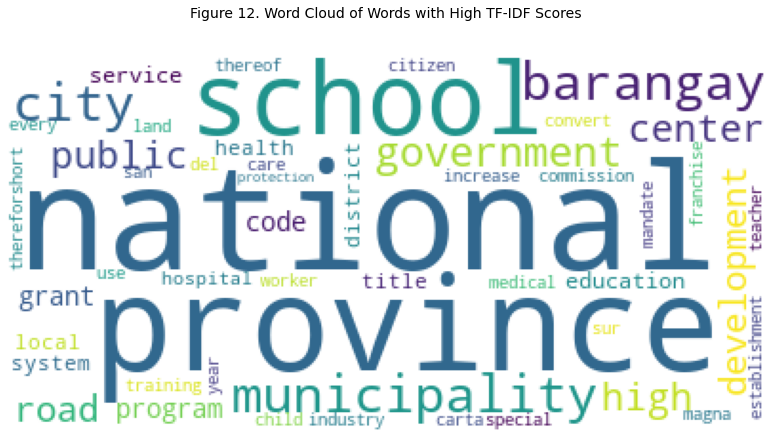

In [69]:
# visualize wordcloud for high TF-IDF scores
stopwords = ['would', 'also', 'act', 'fund', 'purpose', 'establish',
             'therefor', 'amend', 'provide', 'appropriating', 'otherwise',
             'republic', 'philippine', 'know', 'create', 'institutionalize',
             'section', 'institute', 'strengthen', 'appropriate',
             'office', 'authority', 'declare']
tfidf = wordcloud_frame(tfidf, stopwords, coefs)['tfidf_score']
title = 'Figure 12. Word Cloud of Words with High TF-IDF Scores \n\n'
wordcloud_plotting(tfidf, 'viridis', title)

# all titles

In [15]:
df = hbs.copy()
df = hbs_title.rename(columns={'title':'text'})
df = df[['text']]
df

,text
0,"AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E..."
1,AN ACT CREATING THE DEPARTMENT OF OVERSEAS FIL...
2,AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...
3,AN ACT CREATING THE EMERGENCY RESPONSE DEPARTM...
4,AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...
...,...
10035,AN ACT CREATING A DEPARTMENT OF PUBLIC WORKS A...
10036,AN ACT CONVERTING THE LA PAZ DISTRICT HOSPITAL...
10037,AN ACT STRENGTHENING THE CONSERVATION AND PROT...
10038,AN ACT CREATING A NEW BARANGAY IN THE MUNICIPA...


## cleaning

In [71]:
df_en = df
df_tokenized = tokenize(df_en)
df_stopped = remove_stopwords(df_tokenized)
df_stemmed = lemmatize(df_stopped)
df_stemmed.to_csv('hbs_clean.csv', index=None)

AttributeError: 'float' object has no attribute 'lower'

In [18]:
df_stemmed

,text,language,tokenized_text,stopped_text,stemmed_text
0,"AN ACT INSTITUTIONALIZING A NATIONAL VALUES, E...",en,an act institutionalizing a national values et...,act institutionalizing national values etiquet...,act institutionalize national value etiquette ...
2,AN ACT PROVIDING FOR A NATIONAL PROGRAM TO SUP...,en,an act providing for a national program to sup...,act providing national program support care ab...,act provide national program support care aban...
4,AN ACT INSTITUTIONALIZING MICROFINANCE PROGRAM...,en,an act institutionalizing microfinance program...,act institutionalizing microfinance programs a...,act institutionalize microfinance program acce...
7,AN ACT ESTABLISHING THE NATIONAL HEALTH PASSPO...,en,an act establishing the national health passpo...,act establishing national health passport syst...,act establish national health passport system ...
8,AN ACT ESTABLISHING A NATIONAL ECONOMIC DECENT...,en,an act establishing a national economic decent...,act establishing national economic decentraliz...,act establish national economic decentralizati...
...,...,...,...,...,...
10035,AN ACT CREATING A DEPARTMENT OF PUBLIC WORKS A...,en,an act creating a department of public works a...,act creating department public works highways ...,act create department public work highway dist...
10036,AN ACT CONVERTING THE LA PAZ DISTRICT HOSPITAL...,en,an act converting the la paz district hospital...,act converting la paz district hospital munici...,act convert la paz district hospital municipal...
10037,AN ACT STRENGTHENING THE CONSERVATION AND PROT...,en,an act strengthening the conservation and prot...,act strengthening conservation protection phil...,act strengthen conservation protection philipp...
10038,AN ACT CREATING A NEW BARANGAY IN THE MUNICIPA...,en,an act creating a new barangay in the municipa...,act creating new barangay municipality m’lang ...,act create new barangay municipality m’lang pr...


In [20]:
not_en = []
for i in hbs.index.tolist():
    if i not in df_stemmed.index.tolist():
        not_en.append(i)
    else:
        pass
not_en

[1,
 3,
 5,
 6,
 10,
 14,
 21,
 24,
 29,
 30,
 33,
 34,
 39,
 44,
 46,
 48,
 52,
 53,
 54,
 59,
 67,
 68,
 69,
 70,
 71,
 75,
 76,
 86,
 94,
 96,
 97,
 105,
 108,
 109,
 112,
 115,
 121,
 127,
 129,
 130,
 133,
 135,
 140,
 141,
 144,
 146,
 149,
 152,
 159,
 160,
 161,
 163,
 164,
 167,
 173,
 174,
 185,
 187,
 192,
 194,
 200,
 213,
 222,
 231,
 233,
 236,
 237,
 239,
 243,
 247,
 249,
 255,
 256,
 257,
 276,
 280,
 284,
 285,
 293,
 301,
 302,
 314,
 317,
 318,
 325,
 328,
 329,
 330,
 331,
 337,
 338,
 360,
 363,
 367,
 374,
 380,
 383,
 389,
 396,
 397,
 403,
 409,
 416,
 430,
 431,
 438,
 439,
 442,
 443,
 444,
 449,
 453,
 456,
 470,
 474,
 477,
 483,
 486,
 488,
 489,
 498,
 500,
 502,
 504,
 505,
 511,
 513,
 518,
 521,
 523,
 525,
 526,
 529,
 537,
 541,
 544,
 546,
 549,
 556,
 561,
 562,
 566,
 567,
 577,
 581,
 583,
 603,
 607,
 609,
 614,
 619,
 622,
 626,
 632,
 634,
 637,
 638,
 661,
 663,
 666,
 667,
 669,
 670,
 683,
 687,
 697,
 698,
 699,
 706,
 733,
 739,
 742,
 74

In [21]:
len(not_en)

2099

## most common words

In [68]:
# generate the TF-IDF for the titles of house bills
tfidf, coefs = tfidf_converter(df_stemmed['stemmed_text'].values)

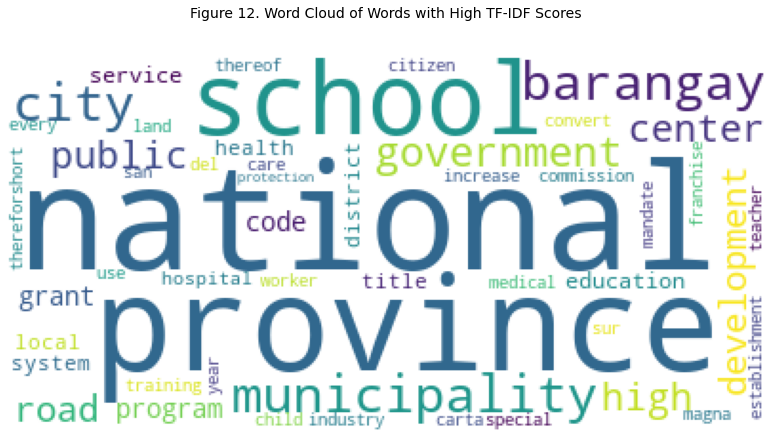

In [69]:
# visualize wordcloud for high TF-IDF scores
stopwords = ['would', 'also', 'act', 'fund', 'purpose', 'establish',
             'therefor', 'amend', 'provide', 'appropriating', 'otherwise',
             'republic', 'philippine', 'know', 'create', 'institutionalize',
             'section', 'institute', 'strengthen', 'appropriate',
             'office', 'authority', 'declare']
tfidf = wordcloud_frame(tfidf, stopwords, coefs)['tfidf_score']
title = 'Figure 12. Word Cloud of Words with High TF-IDF Scores \n\n'
wordcloud_plotting(tfidf, 'viridis', title)